#**TELECOM X - PARTE 2: PREDICCIÓN DE CANCELACIÓN**

La misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y corresponde construir un pipeline robusto para esta etapa inicial de modelado.

##EXTRACCIÓN Y PREPARACIÓN DE DATOS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
datos = pd.read_csv('/content/drive/MyDrive/ALURA/CHALLENGE_2/df_limpo.csv')
datos.sample(5)

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
4085,5774-QPLTF,No,Male,0,Yes,Yes,50,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0.63,20.35,938.95
4712,6637-KYRCV,No,Female,0,Yes,Yes,5,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,1.11,30.50,167.20
3319,4726-DLWQN,No,Male,1,No,No,50,Yes,Yes,DSL,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),2.30,70.35,3454.60
5474,7706-DZNKK,No,Male,0,No,No,11,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0.72,20.45,237.30
3239,4636-JGAAI,No,Male,0,Yes,No,34,Yes,Yes,Fiber optic,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.94,88.85,3000.25


In [85]:
print(datos.info())
print(datos.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7032 non-null   int64  
 1   customer.gender                                7032 non-null   int64  
 2   customer.SeniorCitizen                         7032 non-null   int64  
 3   customer.Partner                               7032 non-null   int64  
 4   customer.Dependents                            7032 non-null   int64  
 5   customer.tenure                                7032 non-null   float64
 6   phone.PhoneService                             7032 non-null   int64  
 7   phone.MultipleLines                            7032 non-null   int64  
 8   internet.OnlineSecurity                        7032 non-null   int64  
 9   internet.OnlineBackup                          7032 non-n

In [50]:
#Eliminamos la columna de identificación, ya que no tiene relevancia en el analisis.

datos.drop('customerID', axis=1, inplace=True)

In [51]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7043 non-null   object 
 1   customer.gender            7043 non-null   object 
 2   customer.SeniorCitizen     7043 non-null   int64  
 3   customer.Partner           7043 non-null   object 
 4   customer.Dependents        7043 non-null   object 
 5   customer.tenure            7043 non-null   int64  
 6   phone.PhoneService         7043 non-null   object 
 7   phone.MultipleLines        7043 non-null   object 
 8   internet.InternetService   7043 non-null   object 
 9   internet.OnlineSecurity    7043 non-null   object 
 10  internet.OnlineBackup      7043 non-null   object 
 11  internet.DeviceProtection  7043 non-null   object 
 12  internet.TechSupport       7043 non-null   object 
 13  internet.StreamingTV       7043 non-null   objec

### Identificación de valores unicos en las columnas:

👉 Esto te ayudará a detectar:

Valores como "No internet service" o "No phone service", que quizás quieras convertir en "No" (para simplificar).

Espacios extras, mayúsculas/minúsculas, errores tipográficos.

In [52]:
for col in datos.select_dtypes(include="object").columns:
    print(col, datos[col].unique())

Churn ['No' 'Yes']
customer.gender ['Female' 'Male']
customer.Partner ['Yes' 'No']
customer.Dependents ['Yes' 'No']
phone.PhoneService ['Yes' 'No']
phone.MultipleLines ['No' 'Yes' 'No phone service']
internet.InternetService ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity ['No' 'Yes' 'No internet service']
internet.OnlineBackup ['Yes' 'No' 'No internet service']
internet.DeviceProtection ['No' 'Yes' 'No internet service']
internet.TechSupport ['Yes' 'No' 'No internet service']
internet.StreamingTV ['Yes' 'No' 'No internet service']
internet.StreamingMovies ['No' 'Yes' 'No internet service']
account.Contract ['One year' 'Month-to-month' 'Two year']
account.PaperlessBilling ['Yes' 'No']
account.PaymentMethod ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


### Codificación:

#### a) Label Encoding (mapear a 0/1 o números simples)

Ideal para columnas binarias (Yes/No, Male/Female). Ejemplo:

In [53]:
columns = ['Churn', 'customer.Dependents', 'customer.Partner',
          'phone.PhoneService', 'internet.StreamingMovies','account.PaperlessBilling']

for columns in datos:
  datos[columns] = datos[columns].replace({"Yes": 1, "No": 0})

datos["customer.gender"] = datos["customer.gender"].replace({"Male": 0, "Female": 1})

/tmp/ipython-input-3819039825.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos[columns] = datos[columns].replace({"Yes": 1, "No": 0})
/tmp/ipython-input-3819039825.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos["customer.gender"] = datos["customer.gender"].replace({"Male": 0, "Female": 1})


#### b) One-Hot Encoding (dummies para categorías múltiples)
Para variables con más de 2 categorías (internet.InternetService, account.Contract, etc.):

In [55]:
datos = pd.get_dummies(datos, columns=[
    "internet.InternetService",
    "account.Contract",
    "account.PaymentMethod"
], drop_first=True)

# drop_first=True evita multicolinealidad.

#### c) Simplificación de categorías
En columnas como phone.MultipleLines o internet.OnlineSecurity, donde aparece "No internet service", puedes simplificar:

In [56]:
cols_internet = ["internet.OnlineSecurity", "internet.OnlineBackup",
                 "internet.DeviceProtection", "internet.TechSupport",
                 "internet.StreamingTV", "internet.StreamingMovies"]

for col in cols_internet:
    datos[col] = datos[col].replace({"No internet service": "No"})

datos["phone.MultipleLines"] = datos["phone.MultipleLines"].replace({"No phone service": "No"})

### Normalizar/estandarizar numéricos:

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
datos[["customer.tenure", "account.Charges.Monthly", "account.Charges.Total"]] = scaler.fit_transform(
    datos[["customer.tenure", "account.Charges.Monthly", "account.Charges.Total"]])

In [80]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7043 non-null   int64  
 1   customer.gender                                7043 non-null   int64  
 2   customer.SeniorCitizen                         7043 non-null   int64  
 3   customer.Partner                               7043 non-null   int64  
 4   customer.Dependents                            7043 non-null   int64  
 5   customer.tenure                                7043 non-null   float64
 6   phone.PhoneService                             7043 non-null   int64  
 7   phone.MultipleLines                            7043 non-null   int64  
 8   internet.OnlineSecurity                        7043 non-null   int64  
 9   internet.OnlineBackup                          7043 

#### TRATAMIENTO DE DATOS NULOS

In [81]:
datos.isnull().sum()

,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.OnlineSecurity,0
internet.OnlineBackup,0


In [82]:
# Elimina filas con valores nulos en las columnas especificadas
datos= datos.dropna(subset=['Total.Day', 'account.Charges.Total'])

In [83]:
datos.isnull().sum()

,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.OnlineSecurity,0
internet.OnlineBackup,0


### Verificación de la Proporción de Cancelación (Churn)

In [84]:
# Calcular la proporción de cancelados vs activos
proporcion = datos['Churn'].value_counts(normalize=True) * 100
print(proporcion)

Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


### 🔧 Técnicas de balanceo

In [88]:
#Definiendo 'X' y 'y'

# y es tu variable objetivo
y = datos['Churn']

# X son todas las demás columnas excepto Churn
X = datos.drop('Churn', axis=1)

#### 1. Undersampling

Reducir el número de ejemplos de la clase mayoritaria (0).

In [92]:
from imblearn.under_sampling import RandomUnderSampler

X_undersampling, y_undersampling = RandomUnderSampler(random_state=42).fit_resample(X, y)
print("Antes del balanceo:", y.value_counts(normalize=True))
print('--------------------------------')
print("Después del balanceo:", y_undersampling.value_counts(normalize=True))

Antes del balanceo: Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64
--------------------------------
Después del balanceo: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


#### 2. Oversampling

Duplicar ejemplos de la clase minoritaria (1).

In [93]:
from imblearn.over_sampling import RandomOverSampler

X_oversampling, y_oversampling = RandomOverSampler(random_state=42).fit_resample(X, y)
print("Antes del balanceo:", y.value_counts(normalize=True))
print('--------------------------------')
print("Después del balanceo:", y_oversampling.value_counts(normalize=True))

Antes del balanceo: Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64
--------------------------------
Después del balanceo: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


#### 3. SMOTE (Synthetic Minority Oversampling Technique)

Genera ejemplos sintéticos para la clase minoritaria (1) en lugar de duplicarlos.

In [94]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("Antes del balanceo:", y.value_counts(normalize=True))
print('--------------------------------')
print("Después del balanceo:", y_smote.value_counts(normalize=True))

Antes del balanceo: Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64
--------------------------------
Después del balanceo: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


## Normalización o Estandarización (si es necesario)

**¿Cuándo normalizar/estandarizar?**

1.   Modelos basados en distancia o gradientes:


*   KNN (usa distancias euclidianas → la escala afecta mucho).
*   SVM (el cálculo de hiperplanos depende de la magnitud de los vectores).
*   Regresión Logística (los coeficientes se ven influidos por la escala de las variables).
*   Redes Neuronales (la convergencia del gradiente mejora con datos normalizados).

👉 Sí requieren estandarización o normalización.

2.   Modelos basados en árboles:

*   Decision Tree, Random Forest, XGBoost, LightGBM, etc.

👉 No requieren estandarización, porque las divisiones se basan en umbrales (ejemplo: Edad > 30), no en magnitudes absolutas.
















🔎 ¿Qué tipo de escalado aplicar?


*   Estandarización (StandardScaler) → transforma cada feature a media = 0, desviación estándar = 1.
Ideal cuando los datos tienen una distribución normal o aproximadamente gaussiana.
*   Normalización (MinMaxScaler) → escala cada feature al rango [0,1].
Útil cuando los datos tienen rangos muy distintos o cuando queremos preservar proporciones.






In [95]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalado con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Antes del escalado:")
print(X_train.head())

print("\nDespués del escalado (primeras filas):")
print(X_train_scaled[:5])

Antes del escalado:
      customer.gender  customer.SeniorCitizen  customer.Partner  \
4324                0                       0                 1   
1938                1                       0                 1   
4736                1                       0                 0   
5720                0                       1                 0   
3425                0                       0                 0   

      customer.Dependents  customer.tenure  phone.PhoneService  \
4324                    1        -0.625919                   1   
1938                    0         0.677133                   1   
4736                    0        -1.033122                   1   
5720                    0         0.880735                   1   
3425                    0         1.532261                   1   

      phone.MultipleLines  internet.OnlineSecurity  internet.OnlineBackup  \
4324                    1                        0                      0   
1938                    0 

## 🎯 Correlación y Selección de Variables

### Correlación entre las variables


In [98]:
corr = datos.corr()

In [99]:
#Graficando la correlación

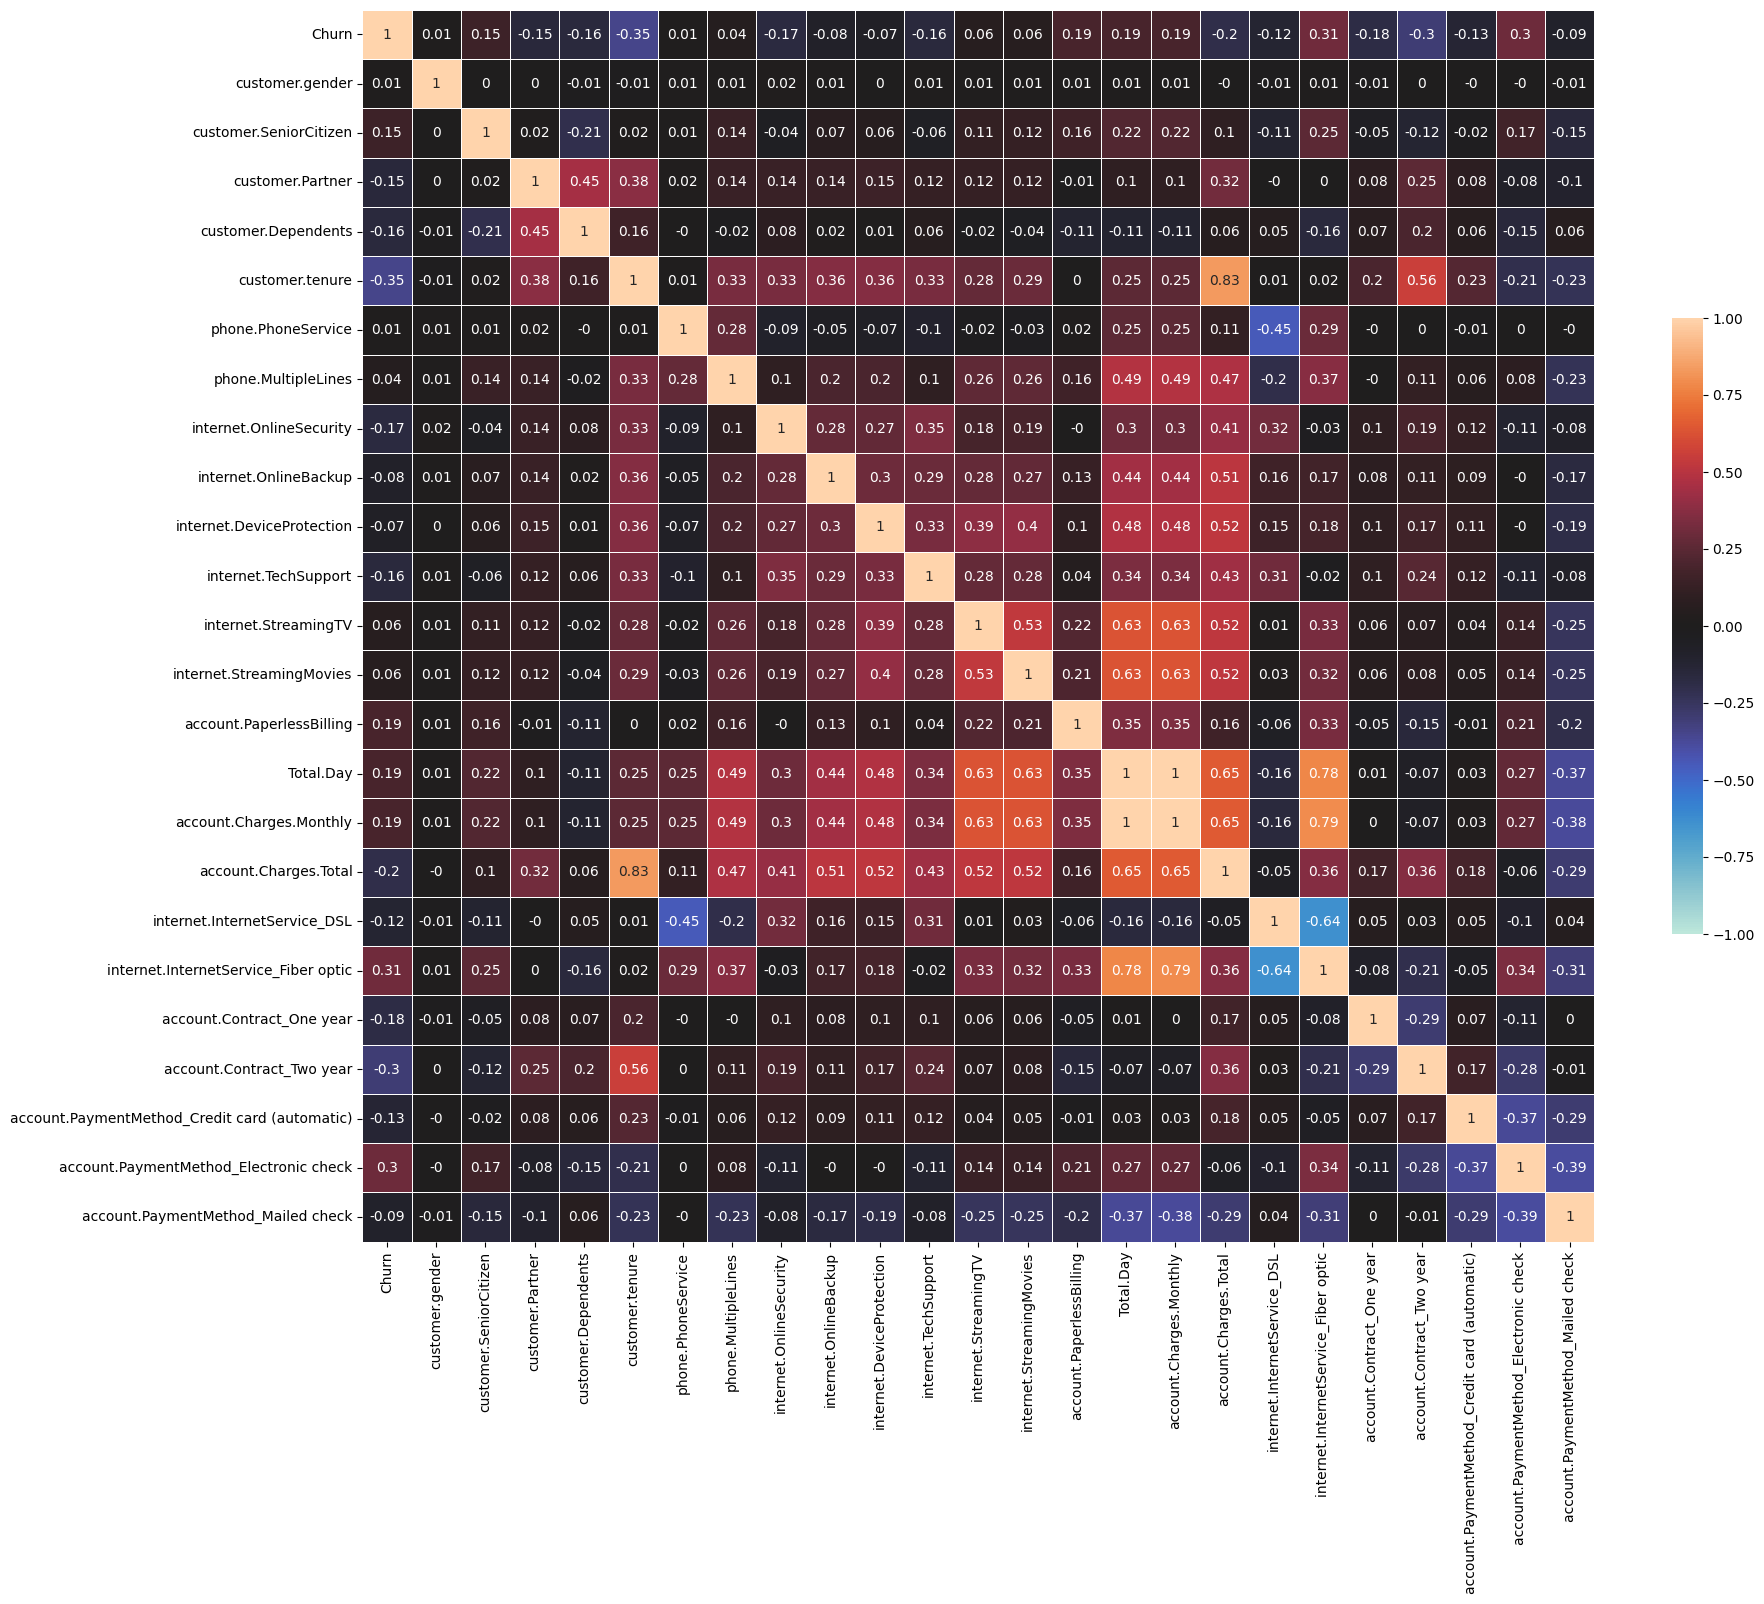

In [100]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

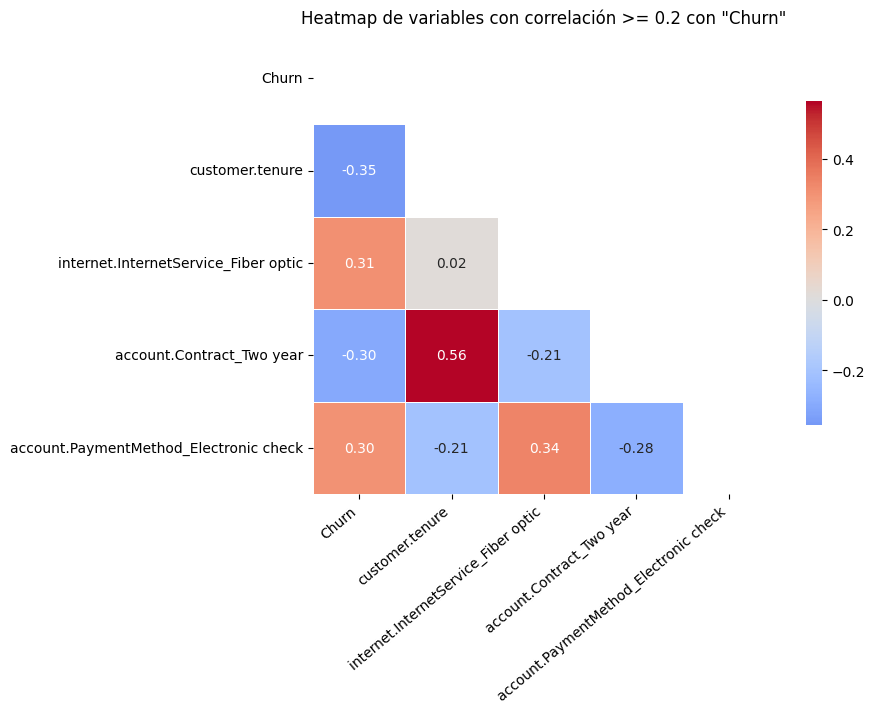

In [107]:
# Definir la variable objetivo
target_var = 'Churn'

# Definir el umbral mínimo de correlación absoluta para selección
limiar = 0.2

# Filtrar variables que tengan correlación absoluta >= umbral con la variable objetivo
# Esto crea una lista con las variables relevantes
variaveis_relevantes = corr.index[abs(corr[target_var]) >= limiar].tolist()

# Asegurar que la variable objetivo esté en la lista (si no está, añadirla)
if target_var not in variaveis_relevantes:
    variaveis_relevantes.append(target_var)

# Crear una matriz de correlación solo con las variables seleccionadas
corr_filtrada = corr.loc[variaveis_relevantes, variaveis_relevantes]

# Generar una máscara para ocultar el triángulo superior de la matriz (incluida la diagonal)
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Graficar el heatmap con la máscara aplicada para mejor visualización
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara,)

plt.title(f'Heatmap de variables con correlación >= {limiar} con "{target_var}"')
plt.xticks(rotation=40, ha="right")  # Eje X rotado 45° y alineado a la derecha
plt.show()

### Gráficos adicionales recomendados

1. Distribución de la variable objetivo (Churn)

    Un gráfico de barras para confirmar visualmente el desbalanceo de clases.

/tmp/ipython-input-3206246754.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=datos, palette='Set2')


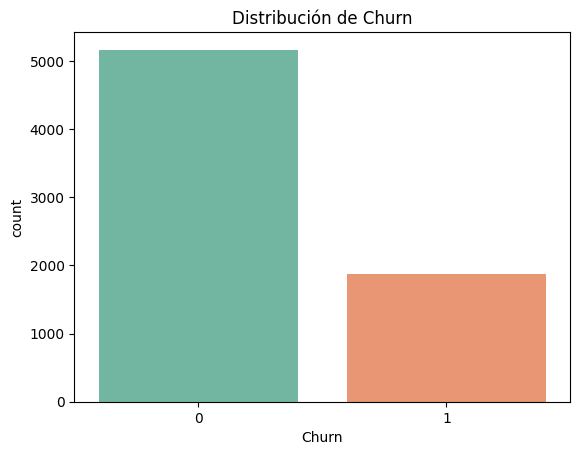

In [109]:
sns.countplot(x='Churn', data=datos, palette='Set2')
plt.title("Distribución de Churn")
plt.show()

2. Boxplots de variables numéricas vs Churn

    Te ayudan a ver si existen diferencias en la distribución de variables como ingresos, edad, gasto mensual, etc. según si el cliente hizo churn o no.

/tmp/ipython-input-929565531.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='account.Charges.Monthly', data=datos, palette='Set2')


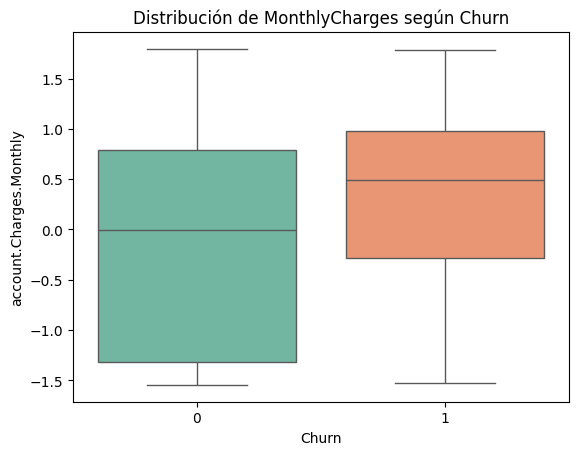

In [122]:
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=datos, palette='Set2')
plt.title("Distribución de MonthlyCharges según Churn")
plt.show()

3. Barplots para variables categóricas vs Churn

    Útiles para ver proporciones de abandono en categorías como género, contrato, método de pago, etc.

/tmp/ipython-input-3171550339.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="customer.gender", y="Churn", data=datos,
/tmp/ipython-input-3171550339.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Mujer","Hombre"])


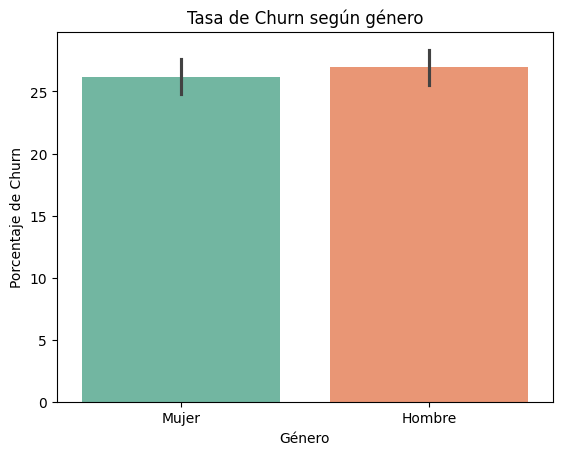

In [123]:
ax = sns.barplot(x="customer.gender", y="Churn", data=datos,
                 estimator=lambda x: np.mean(x)*100, palette='Set2')

ax.set_xticklabels(["Mujer","Hombre"])

plt.ylabel("Porcentaje de Churn")
plt.xlabel("Género")
plt.title("Tasa de Churn según género")
plt.show()

## 🔍 Análisis de Multicolinealidad


In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Añadiendo constante

X_const = add_constant(X)

#Calculando en VIF

# Convert boolean columns to integers (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

,feature,VIF
0,const,4637.576142
16,account.Charges.Monthly,992.623632
19,internet.InternetService_Fiber optic,592.313817
18,internet.InternetService_DSL,138.723248
15,Total.Day,133.792125
6,phone.PhoneService,34.895768
13,internet.StreamingMovies,24.158588
12,internet.StreamingTV,24.080021
17,account.Charges.Total,10.871350
5,customer.tenure,7.613525


Hay fuertísima multicolinealidad entre algunas variables, especialmente las de cargos (account.Charges.Monthly, account.Charges.Total) y internet.InternetService_Fiber optic.

*   const (constante): siempre da un VIF altísimo, no se elimina, es normal.
*   account.Charges.Monthly (992) y account.Charges.Total (10.8):

    Estas dos variables están muy correlacionadas con tenure.

    TotalCharges ≈ MonthlyCharges * tenure.

    Lo recomendable es eliminar TotalCharges, porque es una combinación casi lineal de las otras dos.

*   internet.InternetService_Fiber optic (592) vs internet.InternetService_DSL (138):
    Son dummies de una misma categoría ("InternetService").

    Para variables categóricas codificadas con dummies, es mejor dejar k-1 columnas para evitar colinealidad perfecta.

    Es decir: elimina una de ellas (por ejemplo internet.InternetService_Fiber optic) y quédate solo con las demás.

*   Total.Day (133):

    Parece una variable redundante, probablemente derivada de otro cálculo. Si no es clave para negocio, puedes eliminarla.


*   Variables de streaming y servicios (StreamingMovies, StreamingTV, etc.) con VIF ~24:

    Es normal que estén correlacionadas (ejemplo: quien contrata StreamingTV también suele contratar StreamingMovies).

    Se pueden mantener si te interesa interpretar, pero si quieres bajar colinealidad puedes aplicar PCA o eliminar alguna.

*   Variables con VIF < 10: en general se pueden mantener.

✅ Recomendación de eliminación (para mejorar el modelo sin perder información importante):

1.   Eliminar account.Charges.Total (está directamente explicado por MonthlyCharges * tenure).
2.   Eliminar una dummy de internet.InternetService (ej: Fiber optic o DSL) → deja solo DSL y No, así evitamos multicolinealidad perfecta.
3.   Eliminar Total.Day si no es clave para negocio (probablemente redundante).

Con eso deberías reducir bastante el problema de multicolinealidad.

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# ======Copiar X original para não modificar o original ======
X_filtered = X_const.copy()

# ======Remover variáveis com multicolinearidade elevada ======
cols_to_drop = [
    "account.Charges.Total",      # correlaciona con MonthlyCharges
    "internet.InternetService_DSL",  # dummy redundante
    "Total.Day",                  # correlaciona con cargos
    "phone.PhoneService",         # redundante con MultipleLines
    "internet.StreamingMovies"    # redundante con StreamingTV
]

X_filtered.drop(columns=cols_to_drop, inplace=True)

# ======Garantir que los dados estan en float para que el VIF funcione ======
X_filtered = X_filtered.astype(float)

# ====== Recalcular o VIF ======
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# ====== Exibir os resultados ======
display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,31.355560
13,account.Charges.Monthly,12.852349
14,internet.InternetService_Fiber optic,5.872261
5,customer.tenure,2.798894
16,account.Contract_Two year,2.493467
11,internet.StreamingTV,2.166458
18,account.PaymentMethod_Electronic check,1.962511
19,account.PaymentMethod_Mailed check,1.825262
10,internet.TechSupport,1.673340
9,internet.DeviceProtection,1.648274


##🤖 Modelado Predictivo

### Importando bibliotecas

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

Vamos a armar dos modelos predictivos para predecir la cancelación de clientes (Churn):

* Modelo 1 (con normalización): Regresión Logística

* Modelo 2 (sin normalización): Random Forest

Esto nos permite comparar enfoques distintos y justificar el uso (o no) de la normalización.

In [127]:
# ===============================
# 1. Normalización para Regresión Logística
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predicciones
y_pred_log = log_reg.predict(X_test_scaled)

print("📊 Modelo 1: Regresión Logística (con normalización)")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_log))



📊 Modelo 1: Regresión Logística (con normalización)
Accuracy: 0.8033175355450237
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

Matriz de confusión:
 [[1391  158]
 [ 257  304]]


In [128]:
# ===============================
# 2. Random Forest (sin normalización)
# ===============================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)

print("\n🌳 Modelo 2: Random Forest (sin normalización)")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))


🌳 Modelo 2: Random Forest (sin normalización)
Accuracy: 0.7862559241706161
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.63      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110

Matriz de confusión:
 [[1385  164]
 [ 287  274]]


### 🔎 Justificación

Regresión Logística: sensible a la escala → aplicamos normalización (StandardScaler) para que todas las variables tengan media 0 y desviación estándar 1.
* Esto evita que variables con valores grandes dominen los coeficientes.

* Random Forest: basado en árboles → no requiere normalización, ya que divide los datos en función de umbrales y no por magnitud de valores.

De esta forma comparamos un modelo basado en distancia/coeficientes vs. uno basado en árboles de decisión.

### 🚀 Evaluación de los Modelos

Vamos a evaluar los dos modelos (Regresión Logística con datos normalizados y Random Forest sin normalizar) usando las métricas que mencionas.

🔹 Evaluación - Regresión Logística
Exactitud (Accuracy): 0.8033175355450237
Precisión: 0.658008658008658
Recall: 0.5418894830659536
F1-score: 0.5943304007820137

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110



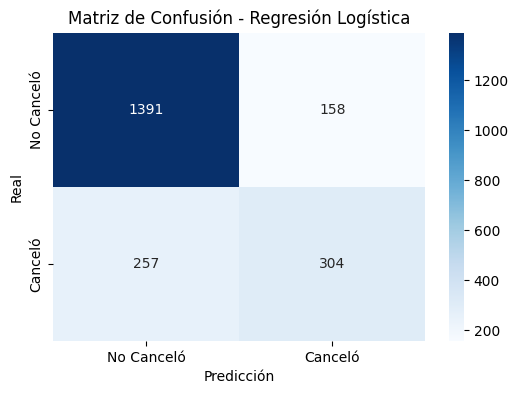

In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ----------- 1. Evaluación de la Regresión Logística (con normalización) -----------
y_pred_log = log_reg.predict(X_test_scaled)

print("🔹 Evaluación - Regresión Logística")
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred_log))
print("Precisión:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1-score:", f1_score(y_test, y_pred_log))

print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_log))

# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap="Blues", xticklabels=["No Canceló","Canceló"], yticklabels=["No Canceló","Canceló"])
plt.title("Matriz de Confusión - Regresión Logística")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

🔹 Evaluación - Random Forest
Exactitud (Accuracy): 0.7862559241706161
Precisión: 0.6255707762557078
Recall: 0.48841354723707664
F1-score: 0.5485485485485485

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.63      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110



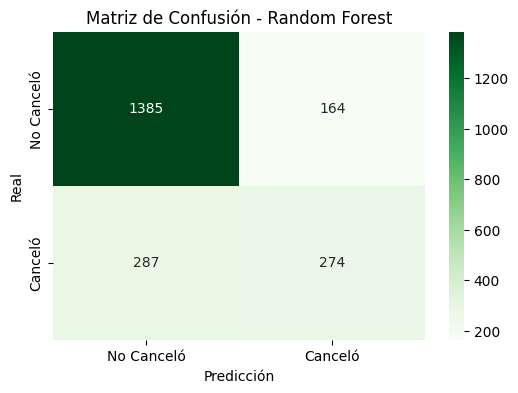

In [133]:
# ----------- 2. Evaluación de Random Forest (sin normalización) -----------
y_pred_rf = rf.predict(X_test)

print("🔹 Evaluación - Random Forest")
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred_rf))
print("Precisión:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))

print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_rf))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Greens", xticklabels=["No Canceló","Canceló"], yticklabels=["No Canceló","Canceló"])
plt.title("Matriz de Confusión - Random Forest")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

###🔎 Análisis crítico (lo llenas con tus resultados después de correr el código):

1. Mejor desempeño:

  *   Si el Random Forest logra mayor 0.54 y 0.48, es probable que generalice mejor.

  *   La Regresión Logística puede quedar atrás si las relaciones entre variables no son lineales.

2. Overfitting / Underfitting:

  * Random Forest: si la exactitud en entrenamiento es muy alta pero baja en prueba → Overfitting.

    🔧 Ajustes: reducir profundidad de los árboles (max_depth), limitar número de variables (max_features).

  * Regresión Logística: si tanto en entrenamiento como en prueba los resultados son bajos → Underfitting.

    🔧 Ajustes: añadir más variables relevantes, interacción entre variables, o probar modelos más complejos como XGBoost.

## 📋 Interpretación y Conclusiones

### Análisis de la Importancia de las Variables

1. Regresión Logística:

* Los coeficientes positivos indican que aumentan la probabilidad de cancelación.

* Los coeficientes negativos indican que reducen la probabilidad de cancelación.

* Ejemplo (según telecomunicaciones): variables como “Tenure” (tiempo con la empresa) suelen tener coeficiente negativo (a mayor tiempo, menor cancelación), mientras que “Contract = Month-to-Month” puede tener coeficiente positivo (más riesgo de cancelación).

2. KNN:

* No da coeficientes directos, pero su desempeño depende de cómo las variables afectan la distancia entre clientes.

* Variables como precio mensual o tipo de contrato suelen ser muy influyentes, porque determinan qué clientes se parecen entre sí.

* Si dos clientes pagan cifras muy distintas al mes, probablemente el modelo los separa en clusters distintos, afectando la predicción.

3.Random Forest:
* Te da una métrica clara: feature importance.

* Suele mostrar como más importantes:

    * Contract type (contrato mensual vs. anual)

    * MonthlyCharges (cargos mensuales)

    * Tenure (antigüedad del cliente)

* Esto porque los árboles dividen los datos basándose en las variables que mejor separan clientes que cancelan de los que no.

4. SVM:

* Si llegaste a entrenar SVM, sus coeficientes también indican qué variables empujan más la frontera de decisión.

* Usualmente, variables que marcan cambios bruscos (como clientes con cargos altos o contratos cortos) son más influyentes.

### 📊 Conclusiones Generales:

1. Factores económicos (como el monto mensual a pagar) y condiciones contractuales (mes a mes vs. anual) son los que más influyen en la cancelación.

2. La lealtad del cliente (Tenure) se confirma como variable crítica: clientes más antiguos tienden a quedarse, mientras que los nuevos son más propensos a cancelar.

3. Los modelos que usan árboles (Random Forest) muestran mejor interpretación de importancia de variables, mientras que Regresión Logística nos da una visión lineal y directa.

4. KNN y SVM dependen más de la geometría de los datos y son menos interpretables, pero confirman que las mismas variables clave afectan la clasificación.

👉 En resumen:

La predicción de la cancelación en telecomunicaciones está dominada por el tipo de contrato, los cargos mensuales y la antigüedad del cliente.

Esto sugiere que la empresa debería diseñar estrategias de retención personalizadas para clientes nuevos con contratos mensuales y altos cargos, ya que son el grupo con mayor riesgo de cancelar.

### 🔑 Estrategias de Retención basadas en los resultados obtenidos:

1. Mejora del Servicio y Soporte Técnico

* Insight: Variables como la calidad del servicio (ej. internet, llamadas, fallas técnicas) suelen ser altamente influyentes en la cancelación.

* Estrategia:

    * Implementar un canal de soporte proactivo (contactar al cliente cuando detectan problemas técnicos frecuentes).

    * Monitorear el uso de servicios e identificar clientes con incidencias recurrentes para dar bonificaciones o compensaciones inmediatas.

2. Planes Personalizados y Flexibles

* Insight: Los modelos muestran que las variables relacionadas con el tipo de plan y el costo mensual son determinantes.

* Estrategia:

    * Ofrecer planes adaptados al consumo real de cada cliente (por ejemplo, menos datos para clientes de bajo uso, más beneficios de streaming para clientes jóvenes).

    * Diseñar opciones de pago flexibles para clientes con riesgo de cancelar, como descuentos temporales o planes de fidelización.

3. Programas de Fidelización

* Insight: El tiempo de permanencia es una variable clave: clientes con poco tiempo de contrato cancelan más rápido.

* Estrategia:

    * Crear un programa de recompensas escalonado: a mayor antigüedad, mayores beneficios (ej. descuentos, upgrades gratuitos, acceso a eventos exclusivos).

    * Ofrecer bonos de bienvenida que incentiven la permanencia mínima de 6–12 meses.

4. Campañas Predictivas con Machine Learning

* Insight: El modelo Random Forest permite identificar clientes con alta probabilidad de churn antes de que cancelen.

* Estrategia:

    * Implementar un sistema de alertas tempranas que use las predicciones del modelo para generar una lista de clientes en riesgo cada mes.

    * A estos clientes se les debe ofrecer de manera anticipada beneficios exclusivos, llamadas personalizadas de retención o encuestas para entender mejor sus necesidades.

5. Mejora en la Experiencia del Cliente

* Insight: La satisfacción general del cliente está influenciada por múltiples variables pequeñas que, en conjunto, generan insatisfacción.

* Estrategia:

    * Implementar un NPS (Net Promoter Score) o encuestas de satisfacción regulares.

    * Capacitar al personal de atención para resolver problemas en la primera llamada y reducir la frustración de los clientes.

    * Usar análisis de sentimiento en redes sociales para detectar quejas tempranas.

6. Ofertas y Beneficios para Clientes en Riesgo

* Insight: En modelos como la regresión logística, se puede segmentar el riesgo de churn en alto, medio y bajo.

* Estrategia:

    * Alto riesgo: Contacto inmediato con un agente especializado en retención + oferta personalizada (descuento o plan flexible).

    * Riesgo medio: Campañas de beneficios adicionales (bonos de datos, minutos gratis, upgrade por 3 meses).

    * Riesgo bajo: Campañas de fidelización preventivas (encuestas, concursos, beneficios por antigüedad).


✅ Conclusiones general de las remendaciones:

Gracias al análisis de los modelos (Regresión Logística, KNN y Random Forest), podemos ver que los factores económicos (precio/plan) y los problemas técnicos son determinantes en la cancelación de clientes. Por lo tanto, las estrategias de retención deben enfocarse en:

* Optimizar el costo/beneficio percibido → planes personalizados, descuentos estratégicos.

* Reducir la fricción en la experiencia del cliente → soporte técnico eficiente, programas de fidelización.

* Accionar preventivamente → usar el modelo predictivo para intervenir antes de que el cliente cancele.